In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
import scipy.stats as stats

from data_processing import *

%load_ext autoreload
%autoreload 2


In [2]:
X, y = get_training_data()
X_testing = get_testing_data()
#Unnamed: 0 is the Id of the row, we can drop it
X = X.drop('Unnamed: 0', axis=1 )

x_testing_id = X_testing['Unnamed: 0']
X_testing = X_testing.drop('Unnamed: 0', axis=1 )
# Unnamed: 0 is the Id of the row, we can drop it
y = y.drop(columns=['Unnamed: 0'])  # If the first column is labeled as 'Unnamed: 0'


### Data exploration

In [3]:
print('Number of elements :', len(X))
print('Number of features :', len(X.columns))

Number of elements : 202944
Number of features : 28


In [4]:
print('len(y):', len(y))

len(y): 202944


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202944 entries, 0 to 202943
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HighBP                202944 non-null  int64  
 1   HighChol              202944 non-null  int64  
 2   CholCheck             202944 non-null  int64  
 3   BMI                   202944 non-null  float64
 4   Smoker                202944 non-null  int64  
 5   Stroke                202944 non-null  int64  
 6   HeartDiseaseorAttack  202944 non-null  int64  
 7   PhysActivity          202944 non-null  int64  
 8   Fruits                202944 non-null  int64  
 9   Veggies               202944 non-null  int64  
 10  HvyAlcoholConsump     202944 non-null  int64  
 11  AnyHealthcare         202944 non-null  int64  
 12  NoDocbcCost           202944 non-null  int64  
 13  GenHlth               202944 non-null  int64  
 14  MentHlth              202944 non-null  float64
 15  

In [6]:
X.isnull().sum()

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
BMI_Category            0
Healthy_Diet            0
Mental_Health_Risk      0
Heart_Disease_Risk      0
Age_Group               0
Education_Level         0
Income_Group            0
dtype: int64

In [7]:
unique_values = {}
for col in X.columns:
    unique_values[col] = X[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['unique value count']).transpose()

,unique value count
HighBP,2
HighChol,2
CholCheck,2
BMI,182669
Smoker,2
Stroke,2
HeartDiseaseorAttack,2
PhysActivity,2
Fruits,2
Veggies,2


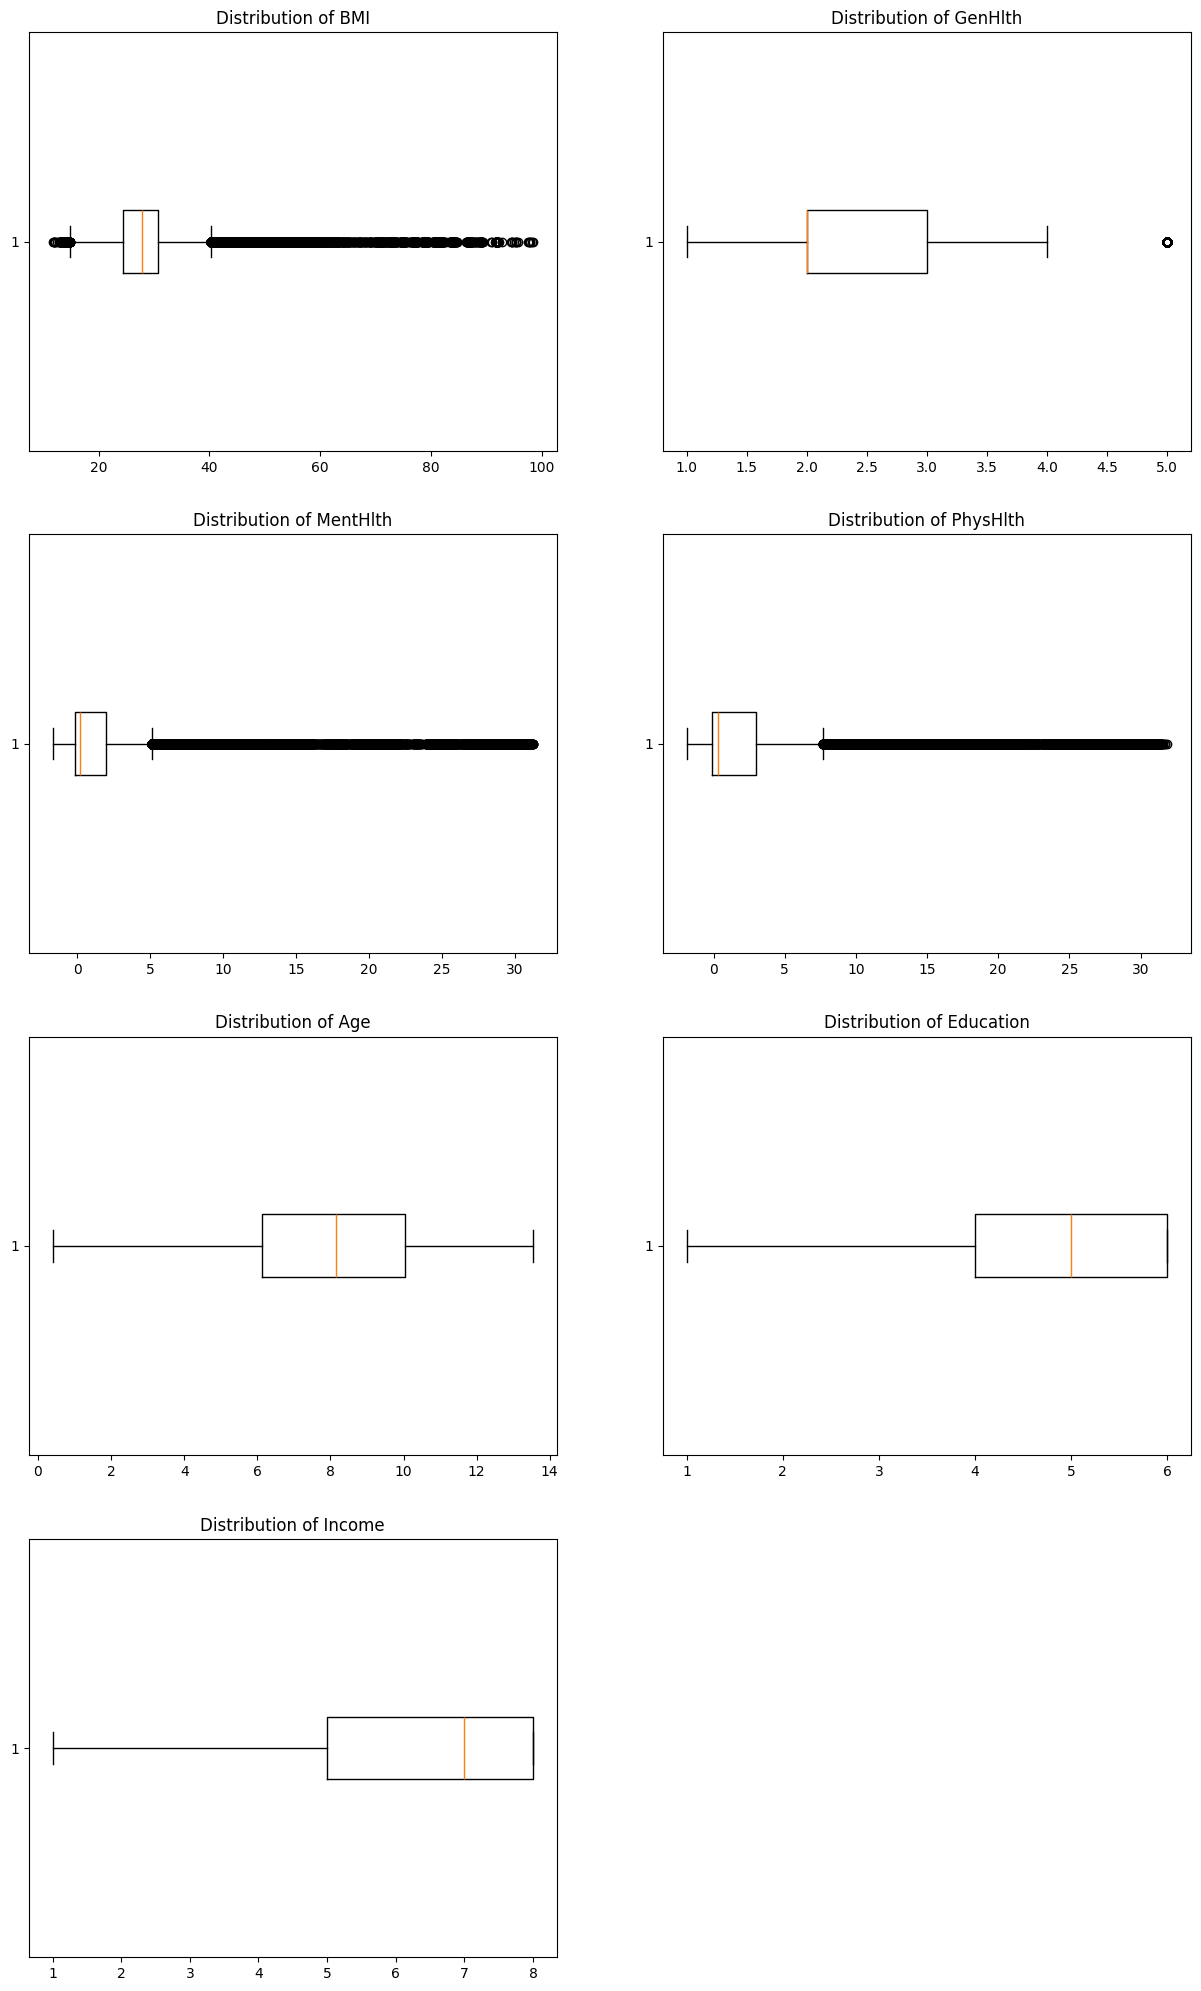

In [8]:
plt.figure(figsize = (15,25))
for i,col in enumerate(['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age','Education', 'Income']):
    plt.subplot(4,2,i+1)
    plt.title('Distribution of '+col)
    plt.boxplot(x = col, data = X, vert=False)
plt.show()

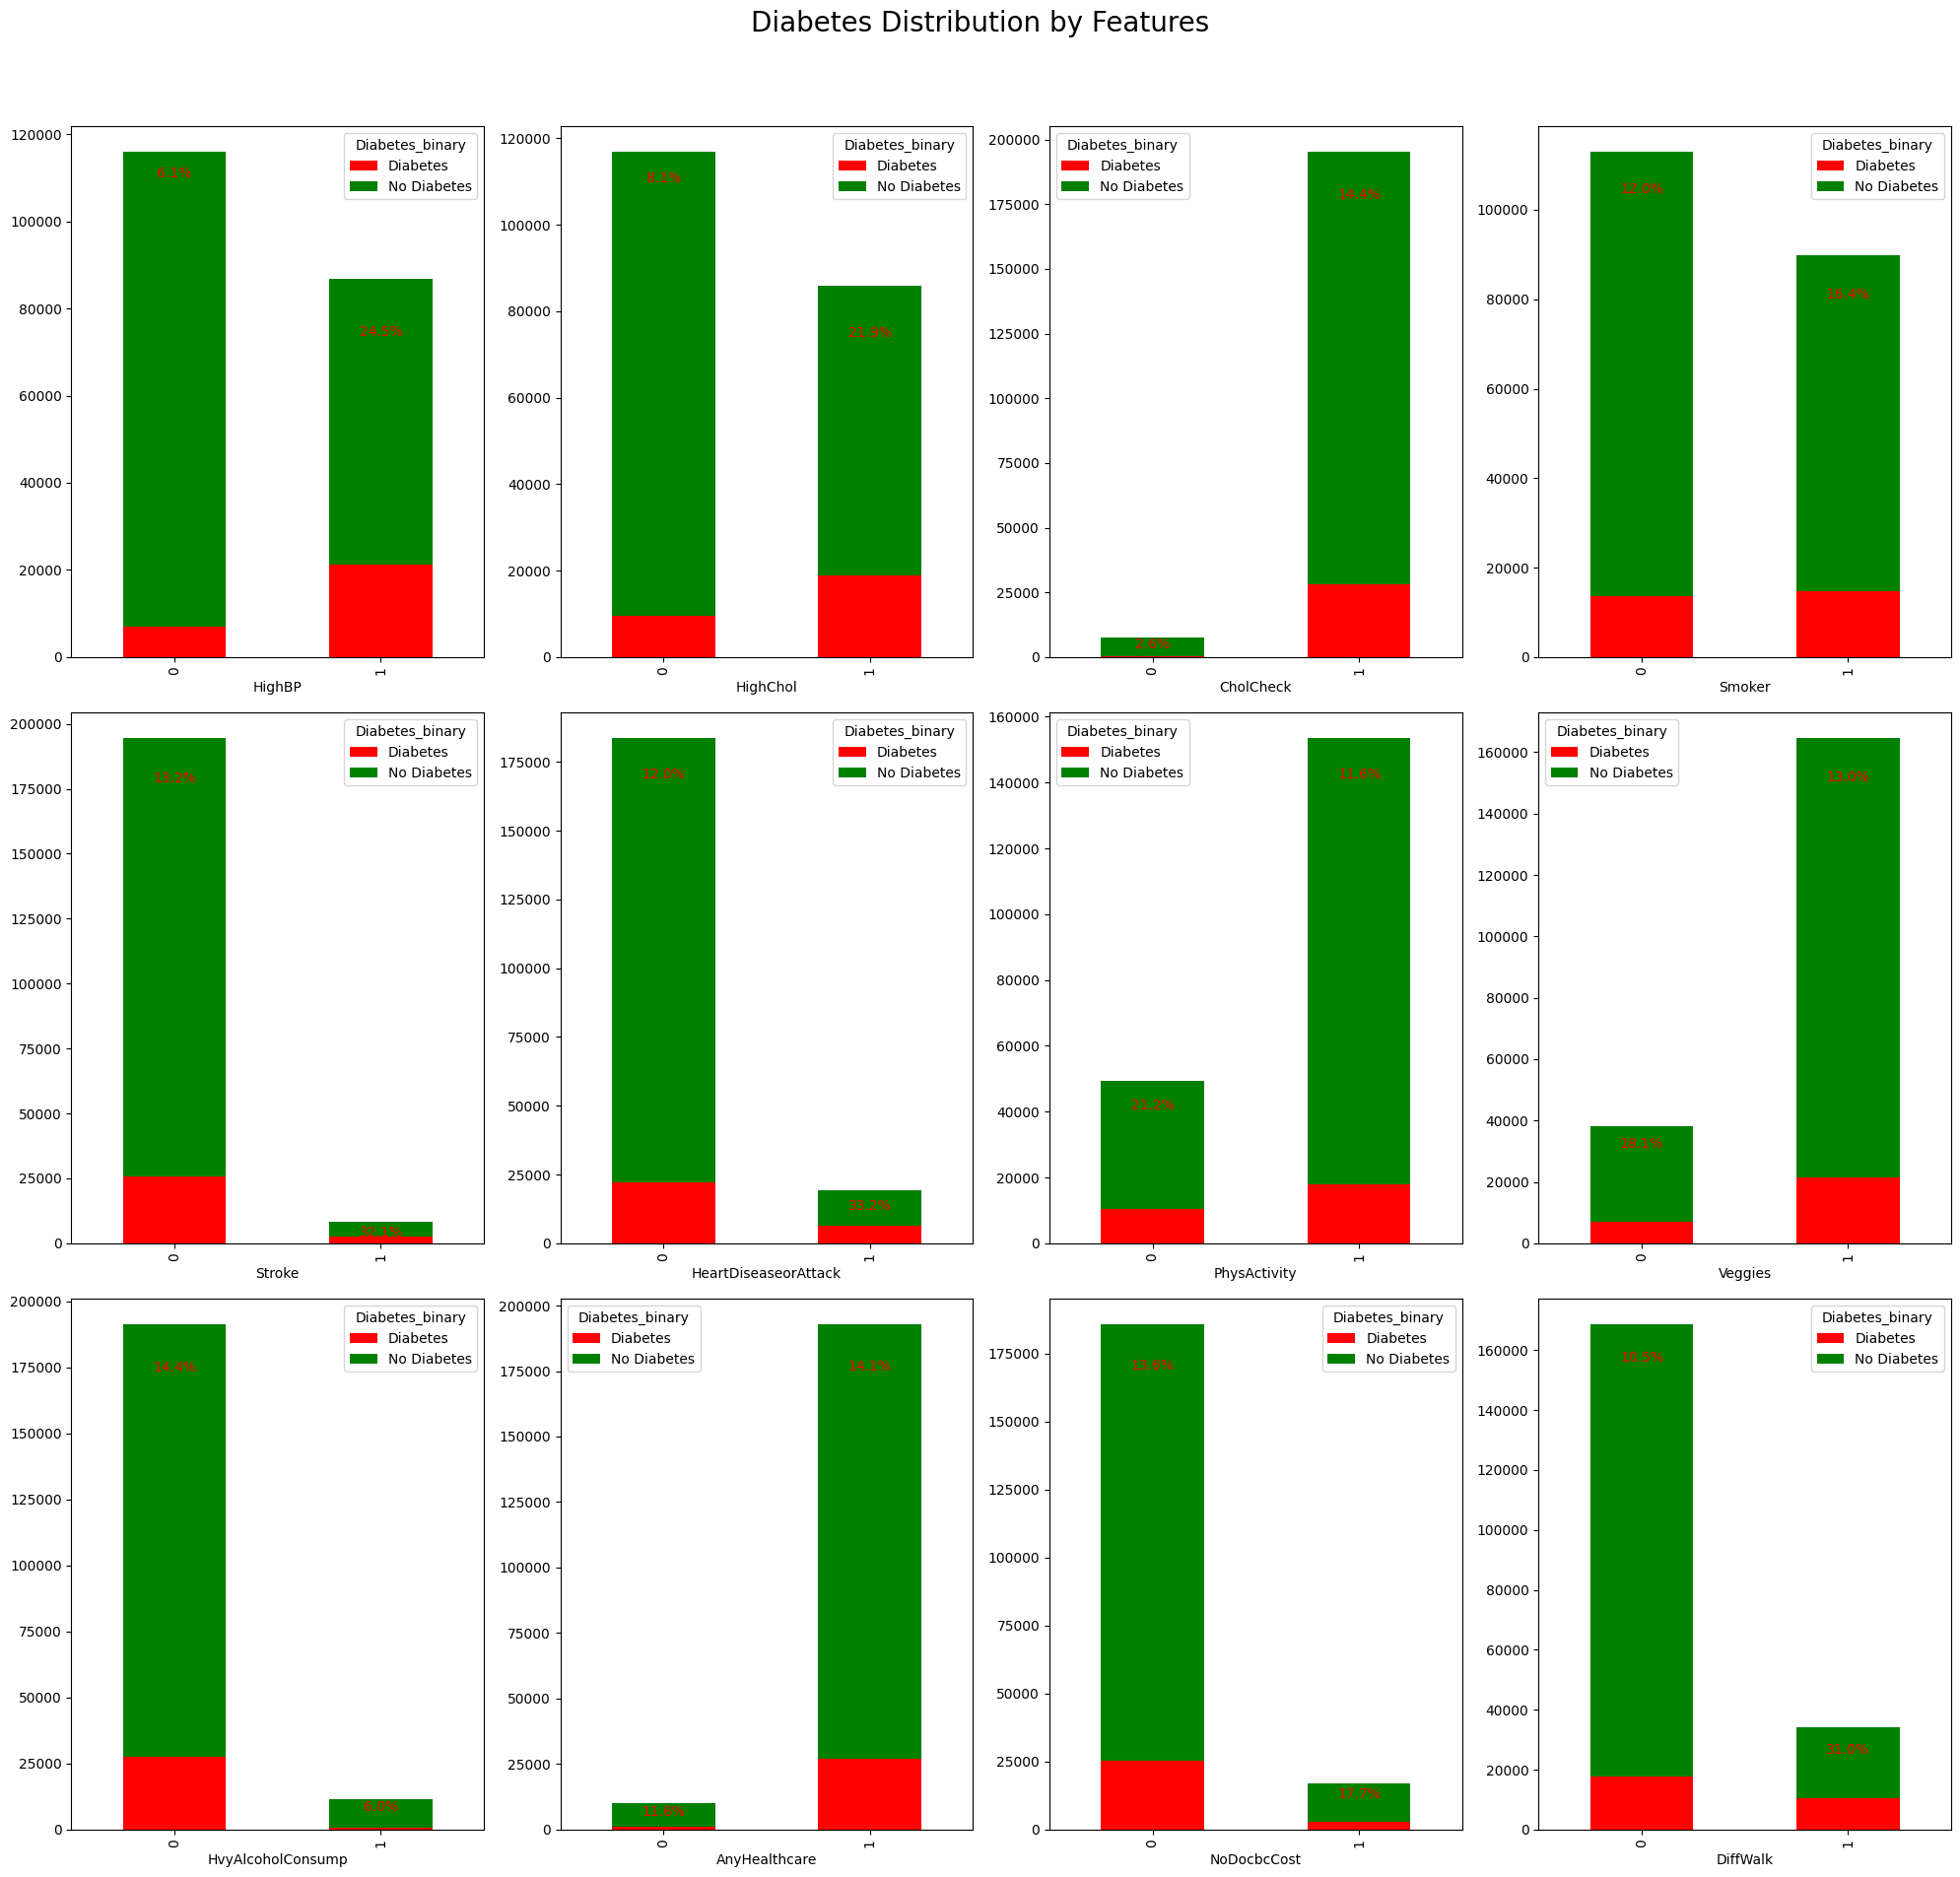

In [9]:
cols = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 
        'PhysActivity', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']

def create_plot_pivot(data, x_column):
    """Create a pivot table for satisfaction versus another rating for easy plotting."""
    # Merge `X` and `y` to ensure access to 'Diabetes_binary' column for grouping
    data_with_target = data.copy()
    data_with_target['Diabetes_binary'] = y['Diabetes_binary']
    data_with_target['Diabetes_binary'] = data_with_target['Diabetes_binary'].replace({0: 'No Diabetes', 1: 'Diabetes'})
    
    _df_plot = data_with_target.groupby([x_column, 'Diabetes_binary']).size() \
                   .reset_index().pivot(columns='Diabetes_binary', index=x_column, values=0)
    return _df_plot

fig, ax = plt.subplots(3, 4, figsize=(20, 20))
axe = ax.ravel()
c = len(cols)
plt.suptitle('Diabetes Distribution by Features', fontsize=20)

# Custom colors for the plot
custom_colors = {'No Diabetes': 'green', 'Diabetes': 'red'}

# Plotting each column in cols
for i in range(c):
    plot_data = create_plot_pivot(X, cols[i])
    plot_data.plot(kind='bar', stacked=True, ax=axe[i], color=[custom_colors[val] for val in plot_data.columns])
    axe[i].set_xlabel(cols[i])
    
    # Adding percentage labels for the "Diabetes" (red) part of each bar
    for j, (index, row) in enumerate(plot_data.iterrows()):
        total = row['No Diabetes'] + row['Diabetes']  # Sum of "No Diabetes" and "Diabetes" counts
        if total > 0:
            diabetes_percentage = (row['Diabetes'] / total) * 100  # Calculate percentage for Diabetes
            axe[i].text(j, row['No Diabetes'] + row['Diabetes'] / 2, 
                        f"{diabetes_percentage:.1f}%", color="red", ha="center", va="top")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()


#### Gaussian distribution

In [10]:

def normal_probability_plot(data, col):
    """
    Generates a normal probability plot for the given data.
    
    Parameters:
        data (array-like): The data for which to generate the plot.
        
    Returns:
        None
    """
    # Generate a probability plot
    stats.probplot(data, dist="norm", plot=plt)
    plt.title("Normal Probability Plot for "+ col)
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.show()

In [11]:
# for col in X.columns:
#     normal_probability_plot(X[col], col)

In [12]:
#Correlation matrix
corr = X.corr()
plt.figure(figsize=(30, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'Normal weight'

### Process the data

In [13]:

# Look for multicollinearity between the features and remove the features that are unnecessary
# we already know the age so age_group is not needed
columnsToDrop = ['Age_Group', 'MentHlth', 'HvyAlcoholConsump', 'NoDocbcCost', 'Smoker', 'Fruits', 'Mental_Health_Risk', 'Education', 'Income', 'Heart_Disease_Risk']
X = X.drop(columns=columnsToDrop)
X = feature_encoding(X)

X_testing = X_testing.drop(columns=columnsToDrop)
X_testing = feature_encoding(X_testing)

X_testing.head()

,HighBP,HighChol,CholCheck,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,Veggies,AnyHealthcare,GenHlth,PhysHlth,DiffWalk,Sex,Age,BMI_Category,Healthy_Diet,Education_Level,Income_Group
0,0,0,1,20.807398,0,0,0,1,1,3,7.182340,0,0,7.018934,0,1,0,1
1,1,1,1,27.690030,0,0,1,1,1,3,0.576965,0,0,13.088206,2,1,2,2
2,0,0,1,24.350989,0,0,1,1,1,1,-0.187868,0,1,0.916045,0,1,0,0
3,0,0,1,27.100812,0,0,1,1,1,2,-0.088216,0,1,2.268324,2,0,0,0
4,0,1,1,30.900910,0,0,0,1,1,4,26.942559,1,0,8.028891,1,1,0,1


### Split validation set and train set

In [14]:
from training import *

In [15]:
X_train, X_validation, y_train, y_validation =  data_splits(X, y) #   split data
X_train_scaled, X_validation_scaled, X_testing_Scaled = normalize_features(X_train, X_validation, X_testing) #   normalize data


In [16]:
cls_decision_tree = DecisionTreeClassifier(random_state=0, max_depth=20, max_leaf_nodes=150, min_samples_leaf=10)
cls_decision_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=20, max_leaf_nodes=150, min_samples_leaf=10,
                       random_state=0)

In [17]:
print(X_train_scaled.shape)
print(X_validation_scaled.shape)

(162355, 18)
(40589, 18)


In [18]:
import numpy as np
from sklearn.utils import gen_batches
def predict_in_batches(cls, X, batch_size=100):
    """
    Make predictions for the input data in batches.
    
    Parameters:
        cls (object): The trained classifier model.
        X (array-like): The input data to make predictions for.
        batch_size (int): The size of each batch.
        
    Returns:
        array-like: The predictions for the input data.
    """
    predictions = []
    
    # Generate batches and make predictions for each batch
    for batch in gen_batches(len(X), batch_size):
        batch_predictions = cls.predict(X[batch])
        predictions.append(batch_predictions)
    
    # Concatenate all batch predictions into a single array
    predictions = np.concatenate(predictions, axis=0)
    return predictions

In [19]:
y_train_pred = predict_in_batches(cls_decision_tree, X_train_scaled)

In [20]:
y_validation_pred = predict_in_batches(cls_decision_tree, X_validation_scaled)

In [21]:
print("y_train shape:", y_train.shape)
print("y_train_pred shape:", y_train_pred.shape)
print(np.unique(y_train, axis=0))


y_train shape: (162355, 1)
y_train_pred shape: (162355,)
[[0]
 [1]]


In [22]:
train_f1 = f1_score(y_train, y_train_pred) #   find f1_score
validation_f1 = f1_score(y_validation, y_validation_pred) #   find f1_score
print("Train f1 score:", train_f1)

print("Validation f1 score:", validation_f1)
print("\nTraining Set Classification Report:")

print(classification_report(y_train, y_train_pred))

print("Training Set Confusion Matrix:")

print(confusion_matrix(y_train, y_train_pred))

print("\nValidation Set Classification Report:")

print(classification_report(y_validation, y_validation_pred))

print("Validation Set Confusion Matrix:")

print(confusion_matrix(y_validation, y_validation_pred))

Train f1 score: 0.2241224445801746
Validation f1 score: 0.20480880648899188

Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    139676
           1       0.61      0.14      0.22     22679

    accuracy                           0.87    162355
   macro avg       0.74      0.56      0.58    162355
weighted avg       0.84      0.87      0.83    162355

Training Set Confusion Matrix:
[[137641   2035]
 [ 19560   3119]]

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.93     34919
           1       0.57      0.12      0.20      5670

    accuracy                           0.86     40589
   macro avg       0.72      0.55      0.57     40589
weighted avg       0.83      0.86      0.83     40589

Validation Set Confusion Matrix:
[[34392   527]
 [ 4963   707]]


In [23]:

cls_randomforest = RandomForestClassifier(random_state=0, max_depth=10, max_leaf_nodes=100, min_samples_leaf=10)


In [24]:
############### TESTING ####################
from sklearn.ensemble import RandomForestClassifier

cls_randomforest = RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=20, max_leaf_nodes=200, min_samples_leaf=20)



In [ ]:
############### TESTING ####################
from sklearn.ensemble import RandomForestClassifier


cls_randomforest = RandomForestClassifier(class_weight='balanced', 
                                          random_state=42, 
                                          max_depth=20, 
                                          max_leaf_nodes=200, 
                                          min_samples_leaf=20)


cls_randomforest.fit(X_train_scaled, y_train)
y_pred = cls_randomforest.predict(X_validation_scaled)
validation_f1 = f1_score(y_validation, y_pred) #   find f1_score
print("Validation f1 score:", validation_f1)
# Get the predicted probabilities for class 1 (positive class)
# y_prob = cls_randomforest.predict_proba(X_validation_scaled)[:, 1]  # Probabilities for class 1
# threshold_list = np.arange(0, 1.1, 0.1)
# threshold_best = 0 
# f1_best = 0

# for threshold in threshold_list:
#     y_pred = (y_prob >= threshold).astype(int)  # Apply threshold
#     validation_f1 = f1_score(y_validation, y_pred) #   find f1_score
#     if validation_f1 > f1_best:
#         f1_best = validation_f1
#         threshold_best = threshold
    # print("Validation f1 score:", validation_f1)
    # print("Classification Report with Adjusted Threshold:")
    # print(classification_report(y_validation, y_pred))

# print("Best Threshold:", threshold_best)
# print("Best F1 Score:", f1_best)


c:\Users\alexi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
print(X_testing.shape)
print(x_testing_id.shape)

In [217]:
# predict on the test set
# y_prob = cls_randomforest.predict_proba(X_validation_scaled)[:, 1]
# y_pred = (y_prob >= threshold_best).astype(int)  # Apply threshold
# save the predictions to a csv file and add back the id column
y_pred = cls_randomforest.predict(X_testing_Scaled)
print(x_testing_id.shape)
print(y_pred.shape)
y_pred = pd.DataFrame({
    'index': x_testing_id , # Add the ID column from x_testing_id
    'Diabetes_binary': y_pred,  # Rename this column to match your target et label if needed
})

# Save the predictions to a CSV file
y_pred.to_csv('./y_pred.csv', index=False)

In [ ]:
cls_randomforest.fit(X_train_scaled, y_train)

In [ ]:
y_train_pred = predict_in_batches(cls_randomforest, X_train_scaled)
y_validation_pred = predict_in_batches(cls_randomforest, X_validation_scaled)

In [ ]:
train_f1 = f1_score(y_train, y_train_pred) #   find f1_score
validation_f1 = f1_score(y_validation, y_validation_pred) #   find f1_score
print("Train f1 score:", train_f1)

print("Validation f1 score:", validation_f1)
print("\nTraining Set Classification Report:")

print(classification_report(y_train, y_train_pred))

print("Training Set Confusion Matrix:")

print(confusion_matrix(y_train, y_train_pred))

print("\nValidation Set Classification Report:")

print(classification_report(y_validation, y_validation_pred))

print("Validation Set Confusion Matrix:")

print(confusion_matrix(y_validation, y_validation_pred))

In [ ]:
# Define a dictionary of model name and their trained model
trained_models = {
        'Decision Tree': cls_decision_tree,
        'Random Forest': cls_randomforest,
        'SVM': cls_svm }

In [ ]:
# predict labels and calculate accuracy and F1score
y_train_pred_dict, y_test_pred_dict, evaluation_results = eval_model(trained_models, X_train_scaled, X_validation_scaled, y_train, y_validation)

# classification report and calculate confusion matrix
report_model(y_train, y_validation, y_train_pred_dict, y_test_pred_dict, trained_models)